In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numpy as np

import sympy as sp
from sympy import symbols
from sympy.physics.units import meter, kilometer, second, hour, minute, kilogram, convert_to, quantities, newton, milli

from my_orbit_lib.extensions import * # strip_units, sp.Vector, sp.norm, np.norm
from my_orbit_lib.constants import *

import my_orbit_lib.epoch
from my_orbit_lib.epoch import Epoch

from datetime import datetime

# Problem 2 - Orbital Corrections

In [3]:
pos_0 = sp.Vector([-5529.203, -2217.254, 3399.353]) * kilometer
vel_0 = sp.Vector([3.049295, 2.478617, 6.576514]) * kilometer/second

## Add Forces to Integrator

Let's modify our integrator to include not just gravity's acceleration, but a function that might apply arbitrary forces.|

In [4]:
def solve_keplers_problem_rk4(pos_0, vel_0, t_0, t_1, hmin, hmax, forces=None, mass=1*kilogram, tol=1e-3, nm=sp):
    """
    pos_0, vel_0, t_0  Describe the initial conditions
    t_1                Up until when to integrate
    hmin               Min time step (pass None to disable adaptive time step)
    hmax               Max time step (h starts at this); we choose an adaptive step based on the tolerance
    tol                If numerical error is bigger than this, then we increase the timestep, if it's 10 times 
                       smaller, we decrease the time step

    forces  Should be None or a function that returns a 3D vector with units newtons
            to be accounted for as acceleration in addition to gravity; we call forces(t, x, v) 
            where 't' is the number of seconds since the epoch of the satellite (usually when 
            the trajectory integration began), and 'x' and 'v' are the position and velocity at 't'.
    
    mass  Should be set if 'forces' are present
    """
    pos_0 = pos_0.copy()
    vel_0 = vel_0.copy()
    if t_1 <= t_0: return pos_0, vel_0, t_0, 0
    
    mu = STANDARD_GRAVITATIONAL_PARAMETER_EARTH
    if nm == np: 
        pos_0 = strip_units(pos_0)
        vel_0 = strip_units(vel_0)
        t_0 = strip_units(t_0)
        t_1 = strip_units(t_1)
        mass = strip_units(mass)
        mu = strip_units(mu)
        tol_vel = tol
        tol_pos = tol
    else:
        tol_vel = tol * kilometer/second
        tol_pos = tol * kilometer
    
    forces_work = 0
    
    if forces is None:
        accel = lambda t, x, v: (-mu * x / nm.norm(x)**3)
    else:
        if nm == np: 
            accel = lambda t, x, v: (-mu * x / nm.norm(x)**3) + forces(t, x, v) / 1000 / mass
        else:
            accel = lambda t, x, v: (-mu * x / nm.norm(x)**3) + convert_to(forces(t, x, v), [kilometer, kilogram, second]) / (strip_units(convert_to(mass, kilogram)) * kilogram)

    h = hmax
    
    while t_0 < t_1:
        k1v = h * accel(t_0, pos_0, vel_0)
        k1x = h * vel_0
        
        k2v = h * accel(t_0 + h/2, pos_0 + k1x/2, vel_0 + k1v/2)
        k2x = h * (vel_0 + k1v/2)
        
        k3v = h * accel(t_0 + h/2, pos_0 + k2x/2, vel_0 + k2v/2)
        k3x = h * (vel_0 + k2v/2)

        k4v = h * accel(t_0 + h, pos_0 + k3x, vel_0 + k3v)
        k4x = h * (vel_0 + k3v)
        
        vel_1 = vel_0 + (k1v + 2 * k2v + 2 * k3v + k4v) / 6
        pos_1 = pos_0 + (k1x + 2 * k2x + 2 * k3x + k4x) / 6

        if hmin is not None:
            # Compute another estimate of the solution with step sizes h/2
            vel_1_smaller_h = vel_0 + (k1v/2 + k2v + k3v + k4v/2) / 6
            pos_1_smaller_h = pos_0 + (k1x/2 + k2x + k3x + k4x/2) / 6
        
            err_vel = nm.norm(vel_1 - vel_1_smaller_h)
            err_pos = nm.norm(pos_1 - pos_1_smaller_h)
            
            # If the error is within the tolerance, accept the solution and increase the step size
            if (err_vel < tol_vel and err_pos < tol_pos) or h == hmin:
                if forces is not None:
                    forces_work += forces(t_0, pos_0, vel_0).dot(pos_1 - pos_0)
                pos_0 = pos_1
                vel_0 = vel_1
                t_0 += h
                h = min(hmax, h*2)
            else:
                # If the error is too large, reject the solution and decrease the step size
                h = max(hmin, h/2)
        else:
            # Don't to adaptive time step if hmin is passed as None
            pos_0 = pos_1
            vel_0 = vel_1
            t_0 += h
    return pos_0, vel_0, t_0, forces_work

In [5]:
pos_0, vel_0

(Matrix([[-5529.203*kilometer, -2217.254*kilometer, 3399.353*kilometer]]),
 Matrix([[3.049295*kilometer/second, 2.478617*kilometer/second, 6.576514*kilometer/second]]))

In [6]:
def engine(t, x, v):
    n = v/sp.norm(v)
    if 3*second < t < 5*second:
        return n * 10e-3 * newton
    else:
        return n * 0 * newton
solve_keplers_problem_rk4(pos_0, vel_0, t_0=0, t_1=10*second, hmin=1e-1*second, hmax=1e2*second, mass=10*kilogram, forces=engine)

(Matrix([[-5498.05740767524*kilometer, -2192.08079705548*kilometer, 3465.56023871361*kilometer]]),
 Matrix([[3.11808407165721*kilometer/second, 2.50612317308751*kilometer/second, 6.53369228499987*kilometer/second]]),
 10.1*second,
 0.160882866263018*kilometer*newton)

Sometimes I think the units are more of a hassle than they are worth, but just now they caught an error for me. I forgot to convert the newtons to kilometer, kilogram, second. UGH. I mean calculations can be wrong in other ways, but at least the formulas are verified.

In [7]:
def engine(t, x, v):
    n = v/np.norm(v)
    return n * (10e-3 if 3<t<5 else 0)
solve_keplers_problem_rk4(pos_0, vel_0, t_0=0, t_1=10, hmin=1e-1, hmax=1e2, forces=engine, mass=10*kilogram, nm=np)

(array([-5498.05740768, -2192.08079706,  3465.56023871]),
 array([3.11808407, 2.50612317, 6.53369228]),
 10.09999999999998,
 0.1608828662630177)

Let's bump up the newtons to see if it's working. 

In [8]:
def engine_np(t, x, v):
    n = v/np.norm(v)
    return n * (5000 if 3<t<5 else 0)

In [9]:
solve_keplers_problem_rk4(pos_0, vel_0, t_0=0, t_1=50, hmin=1e-1, hmax=1e2, forces=engine_np, mass=10*kilogram, nm=np)

(array([-5349.51234213, -2074.77494868,  3762.78983548]),
 array([3.79349395, 2.94154453, 7.22598766]),
 50.00000000000044,
 86033.08361901819)

## Crude Engine

Now let's see how long does it take to reach a target SMA:

In [10]:
def get_specific_energy(x, v):
    return np.norm(v) ** 2 / 2 - strip_units(STANDARD_GRAVITATIONAL_PARAMETER_EARTH) / np.norm(x)

In [11]:
def get_sma(x, v):
    return -strip_units(STANDARD_GRAVITATIONAL_PARAMETER_EARTH) / (2 * get_specific_energy(strip_units(x), strip_units(v)))

The following code is actually subtly really wrong, because rk4 probes multiple times with different time steps and if the time step is too large then it might "think" it has reached SMA target too early. Basically we rely entirely on hmax being a small number. Engine shouldn't store state like this! We make a way more robust system later.

In [12]:
def engine(t, x, v):
    n = v/np.norm(v)

    if engine.off: return n * 0
    
    if get_sma(x, v) < engine.target_sma:
        return n * engine.power
    else:
        print(f"Reached SMA at t={t}.")
        engine.off = True
        return n * 0

In [13]:
engine.off = False
engine.power = 500 # newtons
engine.target_sma = 6950
_ = solve_keplers_problem_rk4(pos_0, 
                          vel_0, 
                          t_0=0, 
                          t_1=3, 
                          hmin=1e-3, 
                          hmax=1e-1, 
                          forces=engine, 
                          mass=10*kilogram, 
                          nm=np)

Reached SMA at t=0.23600000000000018.


As we can see, with $500\ N$ the maneuver is indeed almost impulsive.

In [14]:
engine.off = False
engine.power = 10 * 1e-3 # newtons
engine.target_sma = 6950
_ = solve_keplers_problem_rk4(pos_0, 
                          vel_0, 
                          t_0=0, 
                          t_1=3*24*3600, 
                          hmin=1e0,
                          hmax=1e1,
                          forces=engine,
                          mass=10*kilogram,
                          nm=np)

Reached SMA at t=11880.0.


In [15]:
11880.0/3600

3.3

That's after around 3.2 hours for the $10\ mN$ engine.

## Improve API

Now that's a good rough start but the "API" of this sort-of mini library is not something I'd like to continue working with. The engine stuff in particular is becoming spaghetti. So let's take the time to give it more structure (and also allow to integrate undefinitely until some condition is met, e.g. in this case - until the SMA is raised).

In [16]:
class Satellite:
    def __init__(self, pos, vel, epoch, name='(Unknown)', mass=1*kilogram, engine=None):
        """
        pos, vel, epoch, name, mass  Current satellite state.
        
        engine  A function which should return the thrust in newtons;
                gets called like that: engine(t, x, v) where t is the number
                of seconds since the epoch of the satellite and 'x' and 'v' 
                are the position and velocity of the simulated satellite at 't'.
        """
        self.pos = pos
        self.vel = vel
        self.epoch = epoch
        self.name = name
        self.mass = mass
        self.engine = engine
    
    def update(self, t):
        'Update satellite from a calculated trajectory, this is as if the satellite has traveled along'
        if len(t.points) == 0: return
        if self.epoch.jde != t.epoch_begin.jde:
            print(f"Couldn't update. Satellite epoch ({self.epoch}) is different to the beginning of the trajectory ({t.epoch_begin}).")
            return
        
        self.pos, self.vel = t.points[-1]
        self.epoch = t.epoch_end

In [17]:
class Trajectory:
    def __init__(self, points, epoch_begin, epoch_end, forces_work=[], is_maneuver=False):
        """
        points       Should be an np.array of shape (n, 2, 3), i.e. pos and vel vectors at 'n' points
        is_maneuver  Should be true if the engines were on during the trajectory (this field
                     is just used as metadata for pretty plots. 
        """
        self.points = points
        self.forces_work = forces_work
        self.is_maneuver = is_maneuver
        self.epoch_begin = epoch_begin 
        self.epoch_end = epoch_end

In [18]:
def get_trajectory(satellite, target_epoch=None, duration=None, until_condition_becomes_false=None, step_size=1, hmin=1e-2, hmax=1e2, tol=1e-3):
    """
    Gets the trajectory between two points of time.
    Each trajectory contains an array of points, whose granularity are specified by the argument step_size.

    step_size  Figures out the number of steps by dividing the duration by this;
               the result is how many points you'll get in the result.
               step_size must be sufficiently small when specifying 'until_condition_becomes_false'
               because in that case we check for the condition at each step (and not at each step size).

    There's a number of ways to specify the two points of time:

    1) Set duration parameter to the number of seconds for which to integrate.
    2) Set target_epoch which gets used to figure out the time delta
       from the current satellite epoch and integrate from there.
    3) Set until_condition_becomes_false to a lambda that 
       receives the arguments: n, t, x, v   at each step and 
       returns whether to continue integrating, where

       n  is the step number
       t  is the time since beginning of integration
       x  is the current satellite's position
       v  is the current satellite's velocity 
    """
    if until_condition_becomes_false is not None:
        if target_epoch is not None:
            print("Warning: until_condition_becomes_false is set, ignoring target_epoch")
        if duration is not None:
            print("Warning: until_condition_becomes_false is set, ignoring duration")
        duration = -1
    else:
        if target_epoch is not None:
            if satellite.epoch.jde > target_epoch.jde:
                raise ValueError('Satellite epoch is after target epoch')
            if duration is not None:
                print("Warning: target_epoch is set, ignoring duration")
            duration = (target_epoch.jde - satellite.epoch.jde) * 86400
        else:
            if duration is None:
                raise ValueError('Please specify a duration in one of the following arguments: duration, '
                                 'target_epoch or until_condition_becomes_false.')
            duration = strip_units(convert_to(duration, second))

    pos, vel = strip_units(satellite.pos), strip_units(satellite.vel)
    duration = strip_units(convert_to(duration, second))
    step_size = strip_units(convert_to(step_size, second))
    
    if duration != -1:
        steps = duration/step_size
    else:
        steps = -1
        
    points = [np.array([pos.copy(), vel.copy()])] # Initial point
    forces_work = [0]
    n = 0
    t = 0
    
    duration_condition = lambda: steps != -1 and n < steps
    other_condition = lambda: until_condition_becomes_false is not None and until_condition_becomes_false(n, t, pos, vel)
    
    while duration_condition() or other_condition():
        pos, vel, t, fw = solve_keplers_problem_rk4(pos_0=pos,
                                                vel_0=vel, 
                                                t_0=t,
                                                t_1=t + step_size, 
                                                hmin=hmin,
                                                hmax=hmax,
                                                forces=satellite.engine,
                                                mass=satellite.mass,
                                                tol=tol,
                                                nm=np)
        points.append(np.array([pos.copy(), vel.copy()]))
        forces_work.append(forces_work[-1] + fw)
        n += 1
        
    epoch_begin = satellite.epoch
    epoch_end = Epoch(satellite.epoch.jde + t/86400)
    is_maneuver = satellite.engine is not None
    return Trajectory(np.array(points), forces_work=forces_work, epoch_begin=epoch_begin, epoch_end=epoch_end, is_maneuver=is_maneuver)

This function is a restructured version of the plotter from problem 1: 

In [19]:
def plot_trajectory(trajectories=[], satellite=None, vel_arrow_scale=400, x_view_angle=-75, y_view_angle=25, scale=0.7):
    """
    Plots the trajectories in a nice visualization.
    
    If satellite is not None we plot it's current position and velocity vector 
    and use it's name and epoch for the title.
    """
    
    fig = plt.figure()
    if satellite is not None:
        plt.title(f'Trajectory Plot: {satellite.name}')
    else:
        plt.title('Trajectory Plot')

    ax = fig.add_subplot(1, 1, 1, projection=Axes3D.name)
    ax.view_init(y_view_angle, x_view_angle)
    ax.set_box_aspect((1, 1, 1))
    ax.grid(False)
    
    # Coordinate system arrows
    EARTH_RADIUS = 6371 # km
    r = EARTH_RADIUS * 0.8
    ax.quiver([0], [0], [0], [r], [0], [0], color='r', linewidth = 0.5)
    ax.quiver([0], [0], [0], [0], [r], [0], color='g', linewidth = 0.5)
    ax.quiver([0], [0], [0], [0], [0], [r], color='b', linewidth = 0.5)

    # Plot Earth
    u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
    x = np.cos(u) * np.sin(v)
    y = np.sin(u) * np.sin(v)
    z = np.cos(v)

    r = EARTH_RADIUS
    ax.plot_wireframe(x * r, y * r, z * r, color=(0.1, 0.2, 0.5, 0.2), linewidth=0.5)

    # Plot first satellite position 
    if len(trajectories):
        t = trajectories[0]
        sat_pos, _ = t.points[0]

        label = f'Satellite on {t.epoch_begin.todatetime().strftime("%d/%m/%Y, %H:%M:%S UTC")}'
        sat = ax.scatter([sat_pos[0]], [sat_pos[1]], [sat_pos[2]], label=label,color="green")

    # Plot numerical points
    last_point = None
    last_point_t = None
    
    for trajectory in trajectories:
        if len(trajectory.points) == 0: continue
        
        t_duration = (trajectory.epoch_end.jde - trajectory.epoch_begin.jde) * 86400
        label = 'Engine Burn {:.2f}s'.format(t_duration) if trajectory.is_maneuver else 'Trajectory'
        style = '-.' if trajectory.is_maneuver else '--'
        color = 'cyan' if trajectory.is_maneuver else 'darkorange'
        
        # If we have at least 3 points to form a path...
        if len(trajectory.points) > 2:
            ax.plot(trajectory.points[:, 0, 0], trajectory.points[:, 0, 1], trajectory.points[:, 0, 2], style, label=label, color=color)
            if trajectory.is_maneuver:
                for p in [trajectory.points[0], trajectory.points[-1]]: 
                    ax.scatter(p[0, 0], p[0, 1], p[0, 2], color=color)
        else:
            # else scatter points
            for p in trajectory.points:
                ax.scatter(p[0, 0], p[0, 1], p[0, 2], color=color)
            ax.scatter(-1000000, 0, 0, label=label, color=color) # Legend hack to make sure only one entry appears
        
        if last_point_t is None or (last_point_t.jde < trajectory.epoch_end.jde):
            last_point = trajectory.points[-1]
            last_point_t = trajectory.epoch_end

    # Plot last satellite position 
    if last_point is not None:
        label = f'Satellite on {last_point_t.todatetime().strftime("%d/%m/%Y, %H:%M:%S UTC")}'

        sat_pos, sat_vel = last_point.copy()
        sat_vel *= vel_arrow_scale
        
        sat = ax.scatter([sat_pos[0]], [sat_pos[1]], [sat_pos[2]], label=label)
        ax.quiver([sat_pos[0]], [sat_pos[1]], [sat_pos[2]], [sat_vel[0]], [sat_vel[1]], [sat_vel[2]], color=sat.get_fc())
    
    plt.legend(loc='upper left', bbox_to_anchor=(1.3, 1), borderaxespad=0)

    # Rest of plot
    r = EARTH_RADIUS * scale
    ax.set_xlim(-r, r)
    ax.set_ylim(-r, r)
    ax.set_zlim(-r, r)
    
    ax.set_axis_off()
    fig.axes[0].get_xaxis().set_visible(False)
    fig.axes[0].get_yaxis().set_visible(False)
    plt.axis('off')
    plt.show()

In [20]:
def get_eccentricity_vector(x, v):
    """
    Returns the vector pointing from apoapsis to periapsis 
    with magnitude equal to the orbit's eccentricity
    """
    x = strip_units(x)
    v = strip_units(v)
    h = np.cross(x, v)
    return np.cross(v, h) / strip_units(STANDARD_GRAVITATIONAL_PARAMETER_EARTH) - (x / np.norm(x))

In [21]:
maneuver_1 = []

sat = Satellite(pos=pos_0, 
                vel=vel_0, 
                epoch=Epoch(datetime.utcnow()), 
                name="6U CubeSat", 
                mass=10*kilogram)

print("Beginning, sma:", get_sma(sat.pos, sat.vel), ", e:", np.norm(get_eccentricity_vector(sat.pos, sat.vel)))

t = get_trajectory(sat, duration=0.3*3600)
sat.update(t)
maneuver_1.append(t)

sat.engine = lambda t, x, v: v/np.norm(v) * 500 # newtons
condition = lambda n, t, x, v: get_sma(x, v) < 6950
t = get_trajectory(sat, 
                    until_condition_becomes_false=condition, 
                    step_size=0.0001,
                    hmin=1e-3,
                    hmax=1  # Small step size because burn is nearly impulsive and we need to catch the condition
                    )
sat.update(t)
maneuver_1.append(t)

sat.engine = None
t = get_trajectory(sat, duration=0.5*3600)
sat.update(t)
maneuver_1.append(t)

print("End,       sma:", get_sma(sat.pos, sat.vel), ", e:", np.norm(get_eccentricity_vector(sat.pos, sat.vel)))

Beginning, sma: 6928.222764298304 , e: 0.010012240653176246
End,       sma: 6950.034776244513 , e: 0.011513120442612773


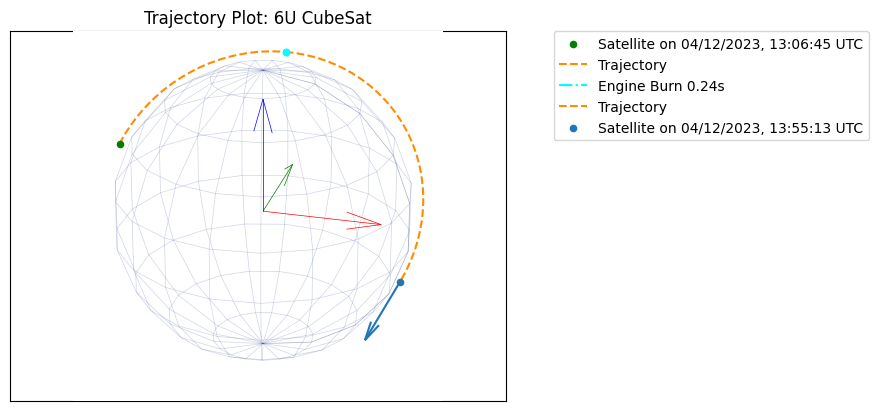

In [22]:
plot_trajectory(trajectories=maneuver_1, satellite=sat)

Weak engine:

In [23]:
maneuver_2 = []

sat = Satellite(pos=pos_0, 
                vel=vel_0, 
                epoch=Epoch(datetime.utcnow()), 
                name="6U CubeSat", 
                mass=10*kilogram)

print("Beginning, sma:", get_sma(sat.pos, sat.vel), ", e:", np.norm(get_eccentricity_vector(sat.pos, sat.vel)))

t = get_trajectory(sat, duration=0.1*3600, hmin=1)
sat.update(t)
maneuver_2.append(t)

sat.engine = lambda t, x, v: v/np.norm(v) * 10 * 1e-3
condition = lambda n, t, x, v: get_sma(x, v) < 6950
t = get_trajectory(sat, 
                    until_condition_becomes_false=condition,
                    step_size=0.1,
                    hmin=1e1)
sat.update(t)
maneuver_2.append(t)

print("End,       sma:", get_sma(sat.pos, sat.vel), ", e:", np.norm(get_eccentricity_vector(sat.pos, sat.vel)))

Beginning, sma: 6928.222764298304 , e: 0.010012240653176246
End,       sma: 6950.000851114675 , e: 0.010080701217055803


The tiny blue dot is where the engine activates (since we add a bit of leeway in the beginning to see the plot). The satellite goes around many times before reaching the desired SMA. This is where an animated plot would be useful.

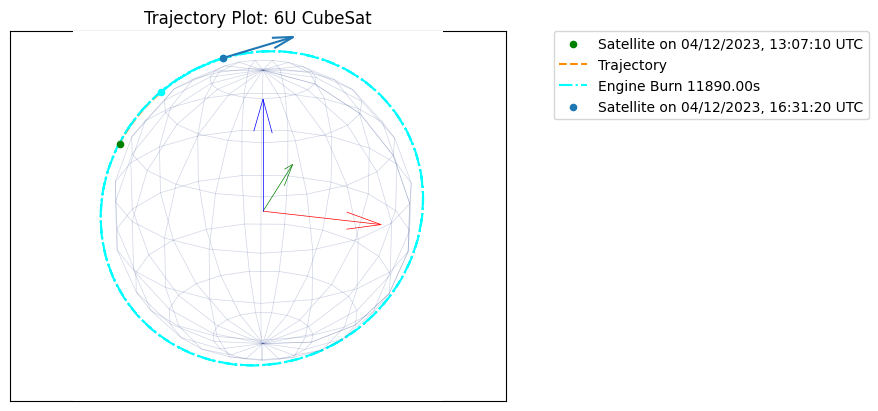

In [24]:
plot_trajectory(trajectories=maneuver_2, satellite=sat)

The resulting orbit from these two methods would be different in terms of the eccentricity.

In theory: In the case of the impulsive delta-v, the spacecraft would experience a sudden change in velocity, resulting in a rapid change in the shape of its orbit. This would cause the orbit to become more elliptical, with a higher eccentricity compared to the initial almost circular orbit. The use of a weak engine would result in a gradual increase in the spacecraft's velocity, resulting in many changes in the shape of the orbit. The resulting orbit would still be slightly elliptical, but with a lower eccentricity compared to the orbit obtained from the impulsive delta-v.

Looking at the print statements above, there's a really small difference - the impulsive burn having a slightly higher eccentricity, while the low-thrust engine keeps essentially the same eccentricity.

Let's see our estimate for the positional error. If we use the old function this won't work, because it will consider our engine adding energy as error. To correct that we need to keep track of the work the engines are doing for the rocket: $W = \vec{F} \cdot \vec{s}$. 

In [25]:
def plot_positional_error(pos_0, vel_0, trajectories, name=''):
    fig, (ax1) = plt.subplots(1)
    
    ax1.set_title("Positional error in SMA")
    ax1.set_xlabel('Time [h]')
    ax1.set_ylabel('Error [m]')
    
    def get_specific_energy_axis(x, v):
        return np.linalg.norm(v, axis=1) ** 2 / 2 - strip_units(STANDARD_GRAVITATIONAL_PARAMETER_EARTH) / np.linalg.norm(x, axis=1)

    E_0 = get_specific_energy_axis([strip_units(pos_0)], [strip_units(vel_0)])
    a_0 = -strip_units(STANDARD_GRAVITATIONAL_PARAMETER_EARTH)/(2 * E_0) * 1000
    
    data = np.array([])
    for trajectory in trajectories:
        n = trajectory.points
        E_err = get_specific_energy_axis(n[:, 0, :], n[:, 1, :]) - trajectory.forces_work
        a_err = -strip_units(STANDARD_GRAVITATIONAL_PARAMETER_EARTH)/(2 * E_err) * 1000
        data = np.append(data, np.abs(a_0 - a_err))
        
    total_duration_h = (trajectories[-1].epoch_end.jde - trajectories[0].epoch_begin.jde) * 86400 / 3600
    x_axis = np.linspace(0, 1, len(data)) * total_duration_h
    ax1.plot(x_axis, data, label=(name+' error') if len(name) else 'Error')
    
    ax1.relim()
    ax1.autoscale_view()
    
    ax1.legend()
    fig.tight_layout()
    plt.show()

For the high-burn engine:

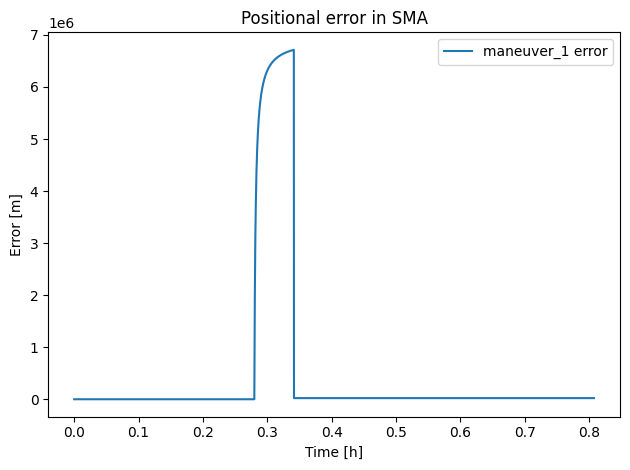

In [26]:
plot_positional_error(pos_0, vel_0, trajectories=maneuver_1, name='maneuver_1')

For the small engine:

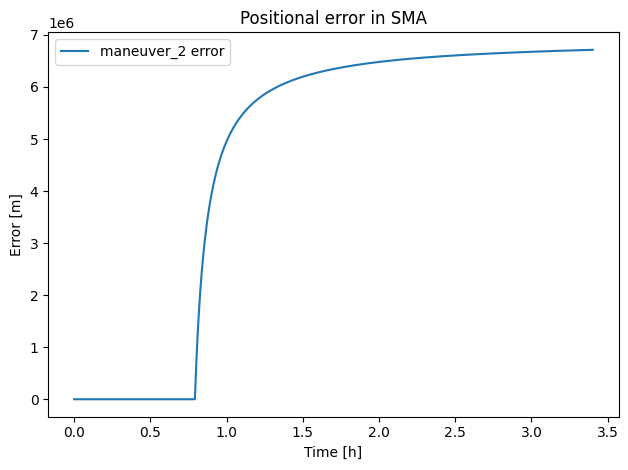

In [27]:
plot_positional_error(pos_0, vel_0, trajectories=maneuver_2, name='maneuver_2')

Both are in the orders of 1e6 (notice the number above the y axis). Which means our numerical integrator must not be introducing a lot of error.

## Analytical Result for High-burn Engine

We wish to raise a $10\ kg$ satellite with $a_0 = 6928.22\ km$ to an orbit with $a_1 = 6950.0\ km$. We'll take the initial state to calculate the radius from the Earth center:

In [28]:
r = sp.norm(pos_0)
r

6858.8557306838*kilometer


The vis-viva equation is:

$$ v = \mu(\frac{2}{r}-\frac{1}{a})$$

So for an impulsive burn, to take the satellite into orbit with $a_1$ we need a new speed of:

In [29]:
v_1 = sp.sqrt(STANDARD_GRAVITATIONAL_PARAMETER_EARTH * (2/r - 1/(6950 * kilometer)))
v_1

7.6728443069423*kilometer/second

In [30]:
v_0 = sp.norm(vel_0)
v_0

7.66108860553838*kilometer/second

Normally we can't just take the norms of the vector to get delta-v, since vectors are complicated, but in this case the engine has a constant anti-velocity direction and we can simplify it to:

In [31]:
dv = v_1 - v_0
dv

0.0117557014039198*kilometer/second

In [32]:
F = convert_to(500 * newton, [kilometer, kilogram, second])
m = 10 * kilogram

a = F/m

dt = dv / a
dt

0.235114028078396*second

This compares well to the numerical result:

In [33]:
(maneuver_1[1].epoch_end.jde - maneuver_1[1].epoch_begin.jde) * 86400 * second

0.237013399600983*second